# UTA

In [272]:
!pip install pulp

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [273]:
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [274]:
ref_ranking = ['2>26', '6>20', '14>23', '3>17', '6=23']
variants = pd.read_csv('Nuclear waste management.csv')
variants.rename(columns={'Unnamed: 0': 'Variant'}, inplace=True)

In [275]:
variants.head()

,Variant,C1,C2,C3,C4
0,1,0.60,0.93,0.00,0.73
1,2,0.66,0.55,0.45,0.49
2,3,1.00,0.45,0.57,0.50
3,4,0.48,0.87,0.00,0.75
4,5,0.62,0.40,0.56,0.50


In [276]:
variants.min()

Variant    1.00
C1         0.32
C2         0.03
C3         0.00
C4         0.49
dtype: float64

In [277]:
def get_pairs(l):
  return [(l[i], l[i + 1]) for i in range(0, len(l), 1) if i + 1 < len(l)]

In [278]:
u1_name = "utilitie1"
u2_name = "utilitie2"
u3_name = "utilitie3"
u4_name = "utilitie4"

def get_uta_problem(use_delta=False):

    # Create a problem variable:
    prob = LpProblem("UTA-GMS", LpMaximize)

    global epsilon
    global delta
    global u1
    global u2
    global u3
    global u4

    # Create problem variables:
    epsilon = LpVariable("e", lowBound=None, upBound=None)
    delta = LpVariable("d", lowBound=None, upBound=None)
    u1 = LpVariable.dicts(u1_name, list(variants['C1'].unique()), lowBound=0, upBound=1)
    u2 = LpVariable.dicts(u2_name, list(variants['C2'].unique()), lowBound=0, upBound=1)
    u3 = LpVariable.dicts(u3_name, list(variants['C3'].unique()), lowBound=0, upBound=1)
    u4 = LpVariable.dicts(u4_name, list(variants['C4'].unique()), lowBound=0, upBound=1)

    if use_delta:
      prob += 10_000 * epsilon - delta, "Profit"
    else:
      prob += epsilon, "Profit"

    # Constraints

    # Ranking constrains
    for pair in ref_ranking:
        if '>' in pair:
            i,j = [int(x) for x in pair.split('>')]
        elif '=' in pair:
            i,j = [int(x) for x in pair.split('=')]
        else:
          raise Exception

        var1 = variants.iloc[i-1]
        var2 = variants.iloc[j-1]

        if '>' in pair:
          prob += u1[var1['C1']] + u2[var1['C2']] + u3[var1['C3']] + u4[var1['C4']] >= u1[var2['C1']] + u2[var2['C2']] + u3[var2['C3']] + u4[var2['C4']] + epsilon
        elif '=' in pair:
          prob += u1[var1['C1']] + u2[var1['C2']] + u3[var1['C3']] + u4[var1['C4']] == u1[var2['C1']] + u2[var2['C2']] + u3[var2['C3']] + u4[var2['C4']]

    # Normalization
    prob += u1[variants.min()['C1']] + u2[variants.min()['C2']] + u3[variants.min()['C3']] + u4[variants.min()['C4']] == 1

    prob += u1[variants.max()['C1']] == 0
    prob += u2[variants.max()['C2']] == 0
    prob += u3[variants.max()['C3']] == 0
    prob += u4[variants.max()['C4']] == 0

    # Monotonicity
    sorted_c1 = sorted(list(variants['C1'].unique()))
    sorted_c2 = sorted(list(variants['C2'].unique()))
    sorted_c3 = sorted(list(variants['C3'].unique()))
    sorted_c4 = sorted(list(variants['C4'].unique()))
    for val1, val2 in get_pairs(sorted_c1):
      prob += u1[val1] >= u1[val2]
    for val1, val2 in get_pairs(sorted_c2):
      prob += u2[val1] >= u2[val2]
    for val1, val2 in get_pairs(sorted_c3):
      prob += u3[val1] >= u3[val2]
    for val1, val2 in get_pairs(sorted_c4):
      prob += u4[val1] >= u4[val2]

    # Non-negativity
    for utility in sorted_c1:
      prob += u1[utility] >= 0
    for utility in sorted_c2:
      prob += u2[utility] >= 0
    for utility in sorted_c3:
      prob += u3[utility] >= 0
    for utility in sorted_c4:
      prob += u4[utility] >= 0

    return prob


In [279]:
prob = get_uta_problem()
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [280]:
def get_utilities_functions(prob):
    utilitie_functions = {
        u1_name: [[],[]],
        u2_name: [[],[]],
        u3_name: [[],[]],
        u4_name: [[],[]],
    }

    for v in prob.variables():
        # print(v.name, "=", v.varValue)
        if 'utilitie' in v.name:
            u_name, u_x = v.name.split('_')
            utilitie_functions[u_name][0].append(float(u_x))
            utilitie_functions[u_name][1].append(float(v.varValue))

    return utilitie_functions

def plot_utilitie_functions(utilitie_functions):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    for idx, (name, (x, y)) in enumerate(utilitie_functions.items()):
        row = idx // 2
        col = idx % 2
        axs[row, col].plot(x, y)
        axs[row, col].set_xlabel('x')
        axs[row, col].set_ylabel('f(x)')
        axs[row, col].set_title(name)
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()


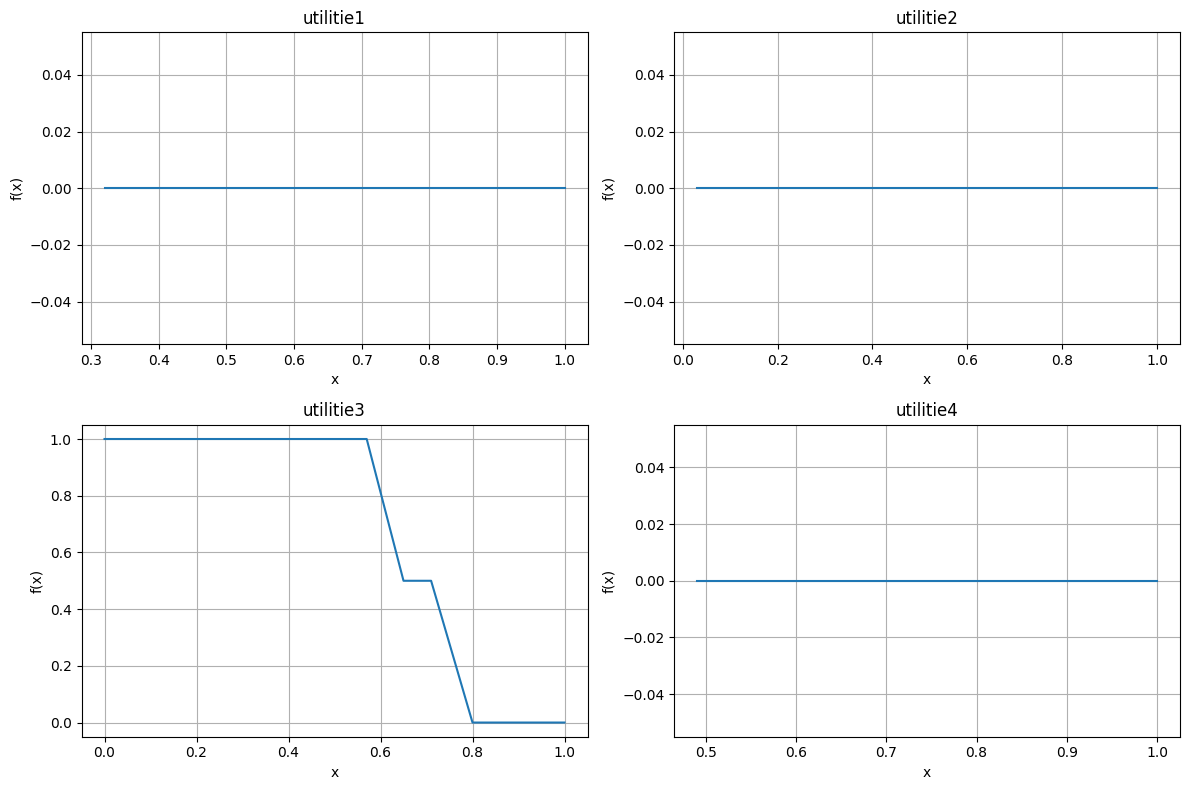

In [281]:
utilitie_functions = get_utilities_functions(prob)
plot_utilitie_functions(utilitie_functions)

In [283]:
def compute_utilitie(row, utilitie_functions):
  u = 0
  for feature, utilitie in [('C1', 'utilitie1'), ('C2', 'utilitie2'), ('C3', 'utilitie3'), ('C4', 'utilitie4')]:
    u_idx = utilitie_functions[utilitie][0].index(row[feature])
    u_value = utilitie_functions[utilitie][1][u_idx]
    u += u_value
  row['U'] = u

  return row

# compute utilities for variants
variants_ranked1 = variants.apply(compute_utilitie, args=(utilitie_functions,), axis=1)

# show ranking
variants_ranked1.sort_values(by="U", ascending=False)

,Variant,C1,C2,C3,C4,U
0,1.0,0.60,0.93,0.00,0.73,1.0
9,10.0,0.45,0.86,0.00,0.73,1.0
21,22.0,0.32,0.83,0.00,0.94,1.0
18,19.0,0.35,0.91,0.00,0.98,1.0
15,16.0,0.44,0.95,0.00,0.90,1.0
1,2.0,0.66,0.55,0.45,0.49,1.0
12,13.0,0.48,0.97,0.00,0.91,1.0
10,11.0,0.61,0.54,0.38,0.49,1.0
13,14.0,0.69,0.49,0.56,0.61,1.0
3,4.0,0.48,0.87,0.00,0.75,1.0


# UTA GMS

In [284]:
possible = np.zeros((variants.shape[0], variants.shape[0]))

for v1_index in range(variants.shape[0]):
  for v2_index in range(variants.shape[0]):
    if v1_index == v2_index:
      continue

    prob = get_uta_problem()

    # check possible relation
    v1 = variants.iloc[v1_index]
    v2 = variants.iloc[v2_index]
    prob += u1[v1['C1']] + u2[v1['C2']] + u3[v1['C3']] + u4[v1['C4']] >= u1[v2['C1']] + u2[v2['C2']] + u3[v2['C3']] + u4[v2['C4']] + epsilon

    prob.solve()

    if value(prob.objective) >= 0:
      possible[v1_index][v2_index] = 1

    print(f"{v1_index * variants.shape[0] + v2_index + 1} / {variants.shape[0]**2}", end='\r')

In [285]:
possible

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],


In [286]:
necessary = np.zeros((variants.shape[0], variants.shape[0]))

for v1_index in range(variants.shape[0]):
  for v2_index in range(variants.shape[0]):
    if v1_index == v2_index:
      continue

    prob = get_uta_problem()

    # check necessary relation
    v1 = variants.iloc[v1_index]
    v2 = variants.iloc[v2_index]
    prob += u1[v2['C1']] + u2[v2['C2']] + u3[v2['C3']] + u4[v2['C4']] >= u1[v1['C1']] + u2[v1['C2']] + u3[v1['C3']] + u4[v1['C4']] + epsilon

    prob.solve()

    if value(prob.objective) <= 0 or LpStatus[prob.status] == 'Infeasible':
      necessary[v1_index][v2_index] = 1

    print(f"{v1_index * variants.shape[0] + v2_index + 1} / {variants.shape[0]**2}", end='\r')

In [287]:
necessary

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],


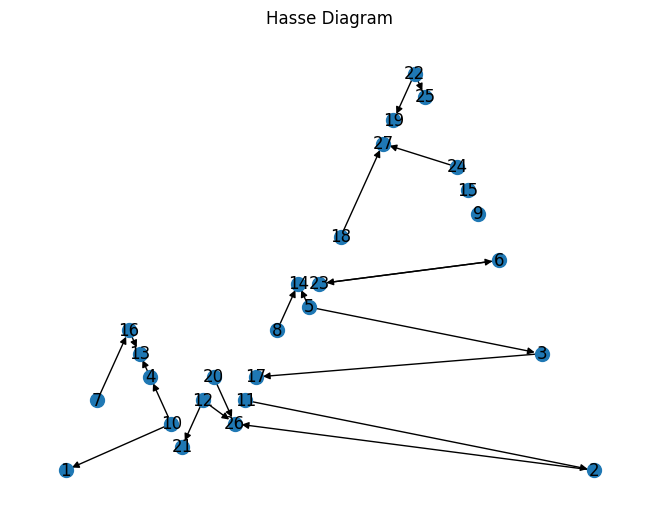

In [297]:
def draw_hasse_diagram(necessary):
    G = nx.DiGraph()

    for i in range(len(necessary)):
        G.add_node(i+1)

    for i in range(len(necessary)):
        for j in range(len(necessary)):
            if necessary[i][j] == 1 and np.max(necessary[np.where(necessary[i] == 1), j]) == 0:
                G.add_edge(i+1, j+1)

    # Draw as planar graph
    pos = nx.planar_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=100)
    plt.title("Hasse Diagram")
    plt.show()


draw_hasse_diagram(necessary)

# Reprezentatywna funkcja użyteczności

In [289]:
prob = get_uta_problem(use_delta=True)

for i in range(necessary.shape[0]):
    for j in range(necessary.shape[0]):
        if necessary[i][j] == 1 and necessary[j][i] == 0:
            v1 = variants.iloc[i]
            v2 = variants.iloc[j]
            prob += u1[v1['C1']] + u2[v1['C2']] + u3[v1['C3']] + u4[v1['C4']] >= u1[v2['C1']] + u2[v2['C2']] + u3[v2['C3']] + u4[v2['C4']] + epsilon
        elif necessary[i][j] == 0 and necessary[j][i] == 0:
            v1 = variants.iloc[i]
            v2 = variants.iloc[j]
            prob += u1[v1['C1']] + u2[v1['C2']] + u3[v1['C3']] + u4[v1['C4']] - u1[v2['C1']] + u2[v2['C2']] + u3[v2['C3']] + u4[v2['C4']] <= delta
            prob += u1[v2['C1']] + u2[v2['C2']] + u3[v2['C3']] + u4[v2['C4']] - u1[v1['C1']] + u2[v1['C2']] + u3[v1['C3']] + u4[v1['C4']] <= delta

prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


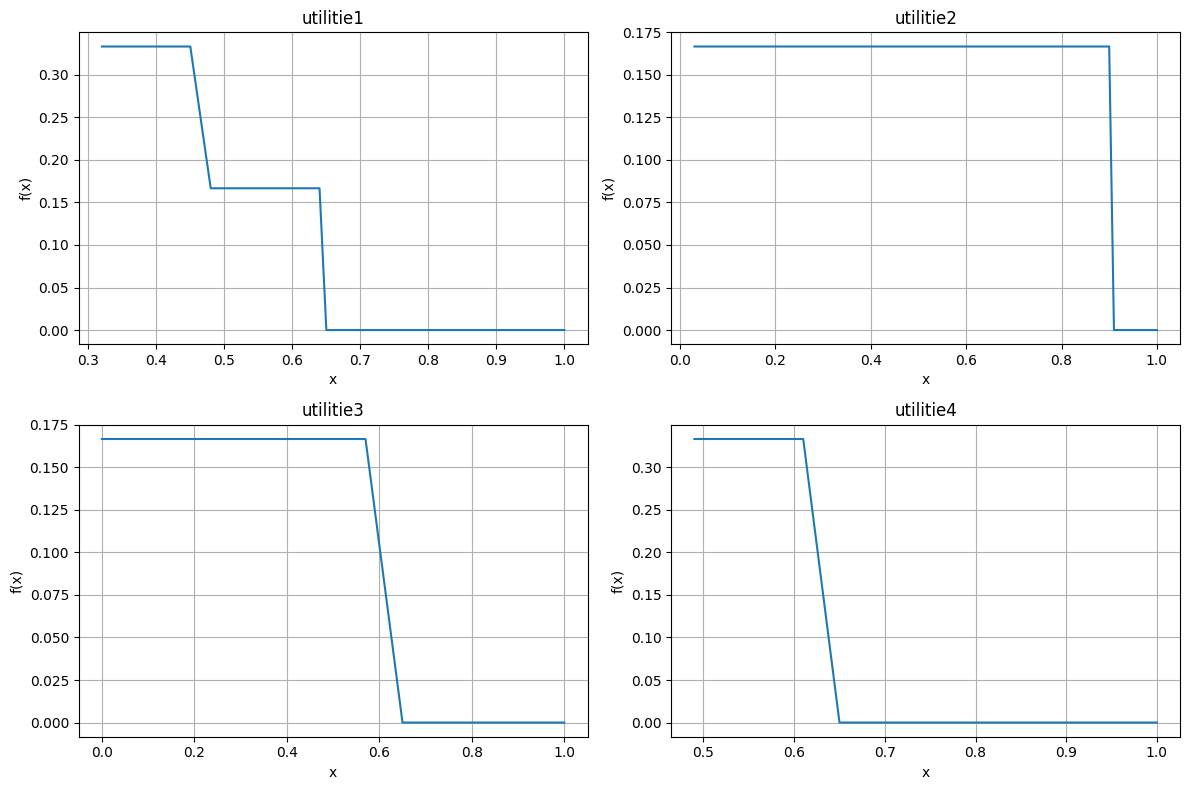

In [290]:
utilitie_functions = get_utilities_functions(prob)
plot_utilitie_functions(utilitie_functions)

In [291]:
# compute utilities for variants
variants_ranked2 = variants.apply(compute_utilitie, args=(utilitie_functions,), axis=1)

# show ranking
variants_ranked2.sort_values(by="U", ascending=False)

,Variant,C1,C2,C3,C4,U
10,11.0,0.61,0.54,0.38,0.49,0.833333
7,8.0,0.64,0.44,0.54,0.54,0.833333
4,5.0,0.62,0.40,0.56,0.50,0.833333
21,22.0,0.32,0.83,0.00,0.94,0.666667
9,10.0,0.45,0.86,0.00,0.73,0.666667
6,7.0,0.40,0.90,0.00,0.82,0.666667
1,2.0,0.66,0.55,0.45,0.49,0.666667
13,14.0,0.69,0.49,0.56,0.61,0.666667
2,3.0,1.00,0.45,0.57,0.50,0.666667
3,4.0,0.48,0.87,0.00,0.75,0.500000
